# Estimating the Entropy of Linguistic Distributions

[insert intro here]

- **Paper**: [Estimating the Entropy of Linguistic Distributions](https://aclanthology.org/2022.acl-short.20) (Arora et al., ACL 2022)
- **Code**: https://github.com/rycolab/entropy-estimation

## Setup

Make sure you have a fairly recent Python version (I am on Python 3.9.12). Run the following:

```
https://github.com/rycolab/entropy-estimation.git
pip install -e .
```

This will install the entropy package with the necessary dependencies.

In [1]:
import entropy

## Basic usage

Say you have a sample which is a list of observations (for example, `heads` and `tails` from flipping a coin). `entropy.prob()` extracts various useful statistics from your sample, which are to be fed to an entropy estimator.

In [2]:
coins = ['heads', 'heads', 'tails', 'tails']
entropy.prob(coins)

([0.5, 0.5], 4, Counter({'heads': 2, 'tails': 2}))

As you can see, `entropy.prob` returns the discrete probability distribution, the number of observations in the sample, and a counter over the sample.

We can run all the estimators in `entropy.funcs` on our sample to see what's available. By default, `entropy` returns estimates in nats. For reference, 1 nat = $\frac{1}{\ln{2}} \approx 1.44$ bits.

In [3]:
for estimator in entropy.funcs:
    print(estimator.__name__, estimator(*entropy.prob(coins)))

mle 0.6931471805599453
miller_madow 0.8181471805599453
jackknife 0.8630462173553428
horvitz_thompson 0.7393569925972749
chao_shen 0.7393569925972749
wolpert_wolf 0.6166666666666667
nsb 1.4118281434807918


Briefly, here is how each of these estimators work:

1. **Maximum Likelihood Estimation (MLE)**: This is the usual naive way to calculate the entropy of a sample--just measure the observed probabilities over outcomes and plug those in as if they were the true values (i.e. we have a model of the distribution that maximises the likelihood of our observations).
2. **Miller-Madow**: Applies a first-order Taylor correction to MLE.
3. **Jackknife**: Using subsamples of our sample, it attempts to project the entropy estimate for the whole sample.
4. **Horvitz-Thompson**: Takes into account the likelihood of an outcome occurring at all in our sample--less-frequent outcomes contribute more to the entropy in order to compensate for MLE's negative bias.
4. **Chao-Shen**: Modifies Horvitz-Thompson to use a coverage-reduced estimate of the probability of the outcomes. Empirically better than it.
5. **Wolpert-Wolf**: First Bayesian entropy estimator with a Dirichlet prior.
5. **Nemenman-Shafee-Bialek (NSB)**: Improves upon Wolpert-Wolf.

For the equations for each and their derivations, see [our paper](https://aclanthology.org/2022.acl-short.20/).

## Experiment 1: A Fair Coin

A fair coin, assigning probablility 0.5 to each heads and tails, would have an entropy of 1 bit $\approx$ 0.6944 nats. How do various estimators converge to the true entropy as we obtain more samples from a fair coin? Here we will simulate 100 coin flips and plot the entropy estimate after each one.

Here is our sample generator:

In [4]:
import random

def coin_flip():
    if random.random() >= 0.5: return 'heads'
    else: return 'tails'

Now we generate the estimates.

In [5]:
X = list(range(100))
estimates = {estimator.__name__: [] for estimator in entropy.funcs}

sample = []
for i in X:
    sample.append(coin_flip())
    stats = entropy.prob(sample) # get necessary statistics
    for estimator in entropy.funcs:
        estimates[estimator.__name__].append(estimator(*stats)) # append estimate

print('First 5 observations:', sample[:5])
print('First 5 MLE entropy estimates:', estimates['mle'][:5])

First 5 observations: ['heads', 'tails', 'heads', 'tails', 'heads']
First 5 MLE entropy estimates: [-0.0, 0.6931471805599453, 0.6365141682948128, 0.6931471805599453, 0.6730116670092565]


Finally, we can plot.

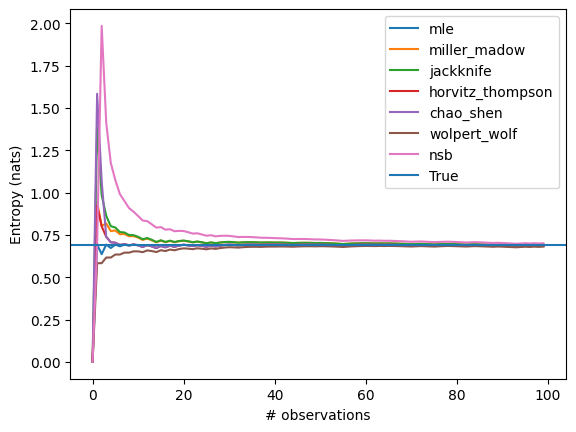

In [6]:
import matplotlib.pyplot as plt
import math

true = math.log(2)
for name, vals in estimates.items():
    plt.plot(X, vals, label=name)

plt.axhline(true, label='True')
plt.legend()
plt.xlabel('# observations')
plt.ylabel('Entropy (nats)')
plt.show()

### Evaluating entropy estimators

While we can sort of eyeball the convergence of each estimators, it would be better to use some statistical metrics to compare their performance. From statistical estimation theory, we know to use the mean squared error (MSE) as a good judge of the bias-variance tradeoff. Let's plot that:

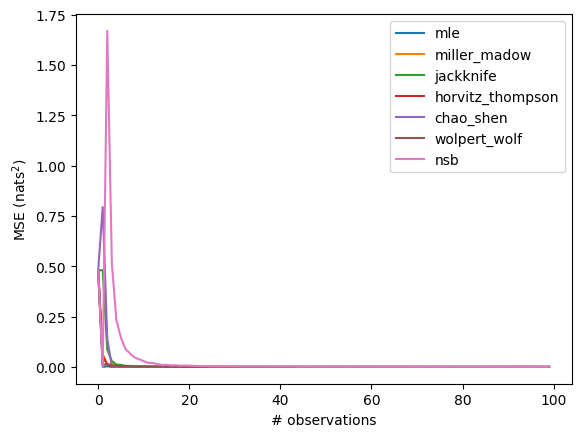

In [11]:
MSEs = {estimator.__name__: [] for estimator in entropy.funcs}
for name in estimates:
    for estimate in estimates[name]:
        MSE = (estimate - true)**2
        MSEs[name].append(MSE)

for name, vals in MSEs.items():
    plt.plot(X, vals, label=name)

plt.legend()
plt.xlabel('# observations')
plt.ylabel('MSE (nats$^2$)')
plt.show()

## Experiment 2: Symmetric Dirichlet distributions

A question that often comes up, given the wide variety of entropy estimators proposed in the information-theoretic literature, is "which estimator is best?". One way to more generally test the performance of estimators is to empirically test their performance over many distributions.

In this section, we'll sample a bunch of distributions from the [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution) (with equal weight for each outcome, hence symmetric) and, over the whole set of distributions we have, plot the MSE and mean bias of the estimators.

In [12]:
import numpy as np
from collections import defaultdict

In [13]:
def sample_dirichlet(distribution):
    obs = random.random()
    total = 0
    for outcome, prob in enumerate(distribution):
        total += prob
        if total >= obs:
            return outcome

Now we generate 100 distributions, each of which will have 5 possible discrete outcomes with probabilities sampled from the Dirichlet.

In [14]:
K = 5
distribs = np.random.dirichlet([1] * K, 100)
distribs[0]

array([0.09336365, 0.43863102, 0.05569544, 0.23931554, 0.17299436])

And now collecting the actual estimates. We'll run the estimators on sample sizes from 1 to 20.

In [94]:
biases = {estimator.__name__: defaultdict(list) for estimator in entropy.funcs}

for key, distrib in enumerate(distribs):
    true_entropy = -sum([x * math.log(x) for x in distrib])
    sample = []
    
    for i in range(20):
        add = sample_dirichlet(distrib)
        sample.append(add)
        
        for estimator in entropy.funcs:
            estimate = estimator(*entropy.prob(sample))
            biases[estimator.__name__][i].append(estimate - true_entropy)

Great, we have our observations! Now let's plot the bias and MSE of the maximum-likelihood estimator. Mathematically, MLE is known to be negatively biased in expectation but does converge to true entropy with greater numbers of samples, so we should expect bias to approach 0 from below and MSE to decrease with sample size. (And indeed, we do see that.)

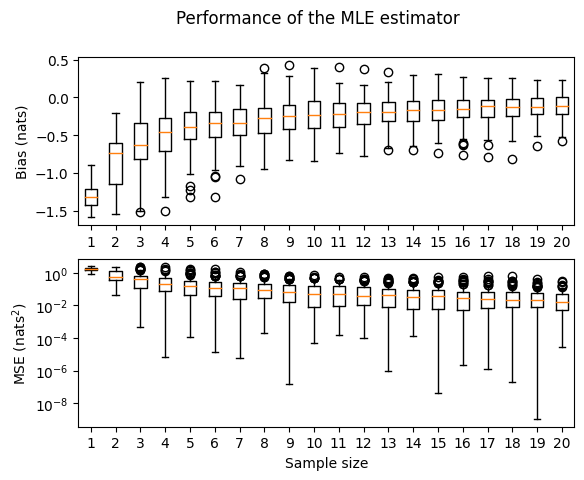

In [95]:
fig, axs = plt.subplots(2)
axs[0].boxplot([biases['mle'][x] for x in biases['mle']])
axs[0].set(ylabel='Bias (nats)')
plt.xlabel('Sample size')
axs[1].boxplot([[z**2 for z in biases['mle'][x]] for x in biases['mle']])
axs[1].set(ylabel='MSE (nats$^2$)', yscale='log')
fig.suptitle('Performance of the MLE estimator')
plt.show()

How do the other estimators fare in comparison? Pretty much everything estimates a higher entropy than MLE, except for the Wolpert-Wolf estimator. Interestingly, the NSB estimator gives a pretty big overestimate before beginning converging down to the true value. All estimators converge to the true entropy gradually--the are provably asymptotically consistent.

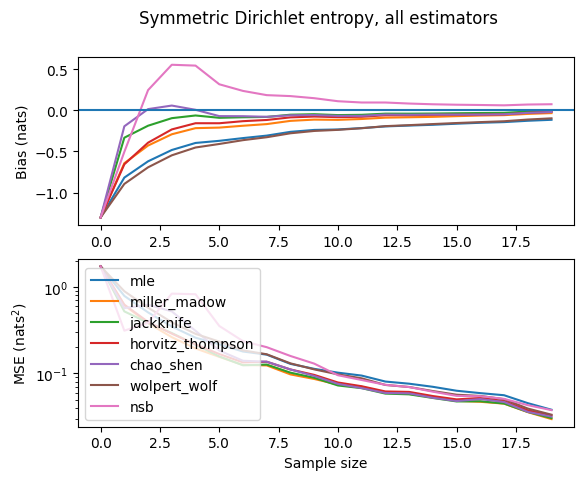

In [98]:
fig, axs = plt.subplots(2)
for estimator in biases:
    avgs = [sum(biases[estimator][sample_size]) / len(distribs) for sample_size in biases[estimator]]
    axs[0].plot(avgs, label=estimator)
axs[0].set(ylabel='Bias (nats)')
axs[0].axhline(0, label='True')
plt.xlabel('Sample size')
for estimator in biases:
    avgs = [sum([x**2 for x in biases[estimator][sample_size]]) / len(distribs) for sample_size in biases[estimator]]
    axs[1].plot(avgs, label=estimator)
axs[1].set(ylabel='MSE (nats$^2$)', yscale='log')
fig.suptitle('Symmetric Dirichlet entropy, all estimators')
plt.legend()
plt.show()

## Experiment 3: Unigram distribution

Now, we'll try an actual linguistic problem where the choice of estimator matters: measuring the entropy of the **unigram distribution**, i.e. the non-contextual distribution over unigram tokens for a particular language.

The language we will estimate the entropy of the unigram distribution of is Mongolian. We will use frequency counts from the Mongolian Wikipedia as the "gold" entropy, and take subsamples from that distribution to run our entropy estimators on. We have processed a file (`mongolian.txt`) which already has the counts of tokens from the Mongolian Wikipedia.

This is a replication of part of [section 4.1 of our paper](https://aclanthology.org/2022.acl-short.20/).

In [26]:
from collections import Counter

counts = Counter()
N = 0
with open('acl_2022/data/LDC96L14/mongolian.txt', 'r') as fin:
    for row in fin:
        row = row.rstrip()
        word, freq = row.split()
        counts[word] += int(freq)
        N += int(freq)

And here's a look at what our data is: raw frequency counts of tokens, from the original corpus of 4.7 million tokens.

In [28]:
print(counts.most_common(10))
print(f'{N} total tokens')

[('нь', 125174), ('оны', 36778), ('юм', 34835), ('онд', 33600), ('байна', 27782), ('болон', 26016), ('байсан', 24806), ('энэ', 22333), ('сарын', 22282), ('бөгөөд', 21971)]
4708173 total tokens


We just need to make the actual probability distribution now for passing to the estimators, which `entropy.prob_counts()` handles. (It's just the frequencies divided by the sum of frequencies, for each class in our distribution.)

We'll also get the "gold" entropy, i.e. the MLE entropy over the whole corpus. This is not the actual unigram entropy for Mongolian, but since our corpus is fairly large it is a good estimate and a baseline to compare our much smaller subsample estimates against.

In [44]:
S = entropy.prob_counts(counts, N)
print(S[:10])

true_entropy = entropy.mle(S, N, counts)
print(f'True entropy: {true_entropy} nats')

[0.02658653367240329, 0.007811522643709141, 0.007398836024079829, 0.007136526206662329, 0.00590080271052062, 0.005525710291444261, 0.0052687103893591, 0.00474345356468422, 0.004732621337406251, 0.004666565990671966]
True entropy: 9.15953158361596 nats


I will use a more efficient sampler than before for this problem because our distribution has a very large sample space. The code is below, but is not really necessary to understand.

In [62]:
from bisect import bisect_left

# precompute partial sums to speed up sampling
distribution = [int(x * N) for x in S]
for i in range(1, len(distribution)):
    distribution[i] += distribution[i - 1]
distribution = [x / N for x in distribution]

# use binary search to find sampled item from random number
def sample_corpus(distrib, sample_size):
    return [bisect_left(distrib, obs) for obs in np.random.rand(sample_size)]

sample_corpus(distribution, 10)

[7, 980, 29191, 688, 16049, 1075, 52, 70, 46704, 463]

Now, we actually get our entropy estimates. We will run our estimators on subsamples of the Mongolian corpus of the size: $10^1, 10^2, 10^3, 10^4, 10^5, 10^6$.

In [85]:
biases = {estimator.__name__: [] for estimator in entropy.funcs}

X = [10, 10**2, 10**3, 10**4, 10**5, 10**6]
for sample_size in X:
    sample = sample_corpus(distribution, sample_size)
    stats = entropy.prob(sample)
    
    for estimator in entropy.funcs:
        estimate = estimator(*stats)
        biases[estimator.__name__].append(estimate - true_entropy)

In [86]:
for estimator in biases:
    print(f'{estimator:<20}:', end=' ')
    for bias in biases[estimator]:
        print(f'{bias:>5.2f}', end=' ')
    print()

mle                 : -6.86 -4.58 -2.68 -1.23 -0.44 -0.11 
miller_madow        : -6.41 -4.10 -2.28 -0.96 -0.31 -0.06 
jackknife           : -5.91 -3.61 -1.93 -0.75 -0.22 -0.03 
horvitz_thompson    : -5.62 -2.01  0.20  1.11  0.85  0.42 
chao_shen           : -4.34 -1.35 -1.62 -0.86 -0.29  0.00 
wolpert_wolf        : -7.06 -4.80 -2.77 -1.08 -0.10  0.20 
nsb                 : -6.86 -0.49 -1.19 -0.44 -0.09  0.02 


As you can see above, we get bias converging to 0 for all the estimators by the time our sample size is $10^6$ (except for Horvitz-Thompson, which gets to a pretty big positive bias but is on the way down). Now let's plot the bias and MSE of all of the estimators.

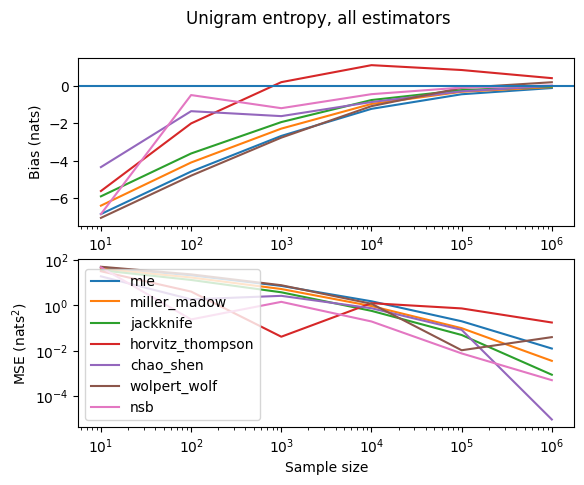

In [92]:
fig, axs = plt.subplots(2)
for estimator in biases:
    axs[0].plot(X, biases[estimator], label=estimator)
axs[0].set(ylabel='Bias (nats)', xscale='log')
axs[0].axhline(0, label='True')
plt.xlabel('Sample size')
for estimator in biases:
    axs[1].plot(X, [x**2 for x in biases[estimator]], label=estimator)
axs[1].set(ylabel='MSE (nats$^2$)', yscale='log', xscale='log')
fig.suptitle('Unigram entropy, all estimators')
plt.legend()
plt.show()